In [1]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

%matplotlib inline

# Explore and clean the data
In this section, we want to explore the data and prepare for image classification. 

In [2]:
# create a df from styles.csv neglecting lines with error
DATASET_PATH = '/mnt/fashion-dataset-1/fashion-dataset/'
styles = pd.read_csv(os.path.join(DATASET_PATH, "styles.csv"), error_bad_lines=False) 

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [3]:
print(styles.head())

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  


In [4]:
print(len(styles))

44424


In [5]:
# Get the list of names of images that are available
imgs_available = os.listdir(DATASET_PATH + '/images')
print(len(imgs_available))

44442


We want to check if each entry in styles.csv has a corresponding images listing. If not, we remove it from the dataframe.

In [6]:
# Check if each entry in styles.csv has a corresponding images listing. 
# If not, we remove it from the dataframe.
missing_img = []
for idx, line in styles.iterrows():
    if not os.path.exists(os.path.join(DATASET_PATH, 'images', str(line.id)+'.jpg')):
        print(os.path.join(DATASET_PATH, 'images', str(line.id)+'.jpg'))
        missing_img.append(idx)
        
styles.drop(styles.index[missing_img], inplace=True)

/mnt/fashion-dataset-1/fashion-dataset/images/39403.jpg
/mnt/fashion-dataset-1/fashion-dataset/images/39410.jpg
/mnt/fashion-dataset-1/fashion-dataset/images/39401.jpg
/mnt/fashion-dataset-1/fashion-dataset/images/39425.jpg
/mnt/fashion-dataset-1/fashion-dataset/images/12347.jpg


In [7]:
print(len(styles))

44419


## Getting the top articleTypes 

In [8]:
# Check how many unique article types we have
uniquie_article_types = styles['articleType'].unique()
print(len(uniquie_article_types))

142


There are 142 distinct articleTypes. In the next cell we are going to see what are the top 20 of them.

In [9]:
top_classes = styles.groupby(['articleType']).size().nlargest(20).sort_values()
print(top_classes)

articleType
Jeans                     608
Perfume and Body Mist     613
Formal Shoes              637
Socks                     686
Backpacks                 724
Belts                     813
Briefs                    849
Sandals                   897
Flip Flops                914
Wallets                   936
Sunglasses               1073
Heels                    1323
Handbags                 1759
Tops                     1762
Kurtas                   1844
Sports Shoes             2036
Watches                  2542
Casual Shoes             2845
Shirts                   3215
Tshirts                  7066
dtype: int64


# Transfer Learning / Fine tuning

### As first, we create master train and test splits of the valid image data, with everything in even years used for the training set, and everything in an odd year used for the test split.
Before doing that, we should check if there are any entries with not valid articleType or year and remove them

In [10]:
styles.dropna(inplace=True, subset=['year','articleType'])
len(styles)

44418

In [11]:
training_data = styles[styles['year'].astype('int') % 2 == 0]
test = styles[styles['year'].astype('int') % 2 == 1]

### Next, let us create sub-splits of the training data for pre-training and fine tuning 
We will do it as follows:
* the top 20 classes (see above) - about 3/4 of the data; and
* all other classes - about 1/4 of the data

In [12]:
top_classes_names = list(top_classes.index)

In [13]:
training_top20 = training_data[training_data.articleType.isin(top_classes_names)]
training_others = training_data[-training_data.articleType.isin(top_classes_names)]

### Creating Fashion Image Dataset class and constructing datasets and dataloaders

In [14]:
# Create a mapping between article types and their ids
cat_list = uniquie_article_types
cat2num = {cat:i for i, cat in enumerate(cat_list)}
num2cat = {i:cat for i, cat in enumerate(cat_list)}

In [15]:
# Create data transform
transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize((224, 224)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

In [16]:
class FIDataset(Dataset):
    """ Fashion Image Dataset
    """
    
    def __init__(self, dir, dataframe, transform):
        super(FIDataset, self).__init__()
        self.dataframe = dataframe
        self.dir = dir
        self.transform = transform
        
    def __getitem__(self, idx):
        line = self.dataframe.iloc[idx]
        cat = line.articleType
        cat_id = cat2num[cat]
        img_path = os.path.join(self.dir, str(line.id)+'.jpg')
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img)
        return img_tensor, cat_id
            
    def __len__(self):
        return len(self.dataframe)

In [17]:
# Construct datasets and dataloaders
train_top20_data = FIDataset(os.path.join(DATASET_PATH, 'images'), training_top20, transform)
train_others_data = FIDataset(os.path.join(DATASET_PATH, 'images'), training_others, transform)
test_data = FIDataset(os.path.join(DATASET_PATH, 'images'), test, transform)

train_top20_loader = DataLoader(train_top20_data, batch_size=16, shuffle=True)
train_others_loader = DataLoader(train_others_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

### Visualizing sample data from the training dataset

In [18]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [19]:
def plot_sample_data(dataloader, num):
    # obtain one batch of training images
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    # convert to numpy for display
    images = images.numpy() 
    labels = labels.numpy() 
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    # display images
    for idx in np.arange(num):
        ax = fig.add_subplot(1,5, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        ax.set_title(num2cat[labels[idx]])

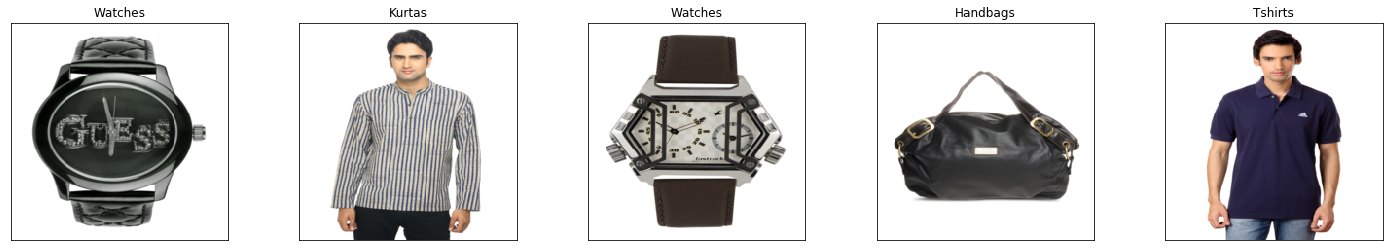

In [20]:
# Plot sample data from the training dataset of top 20 classes
plot_sample_data(train_top20_loader,5)

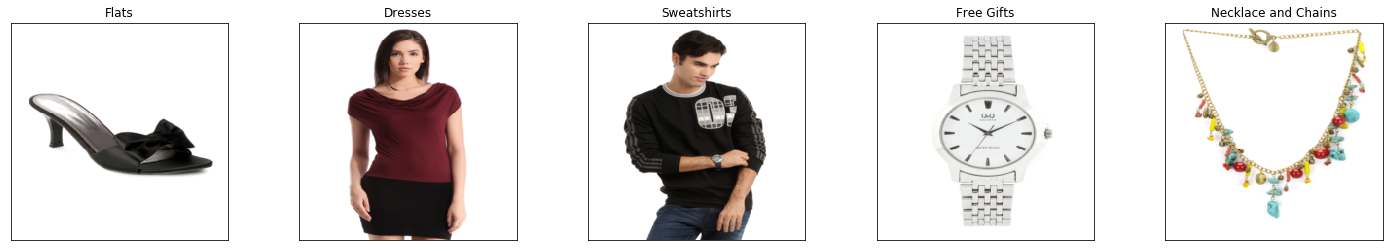

In [21]:
# Plot sample data from the training dataset of not top 20 classes
plot_sample_data(train_others_loader,5)